# Implementing the model based in the paper \[[1](https://dl.acm.org/doi/abs/10.1145/3616388.3617533)\]

[1] [Yakan, Hadi, et al. "Federated Learning for V2X Misbehavior Detection System in 5G Edge Networks." Proceedings of the Int'l ACM Conference on Modeling Analysis and Simulation of Wireless and Mobile Systems. 2023.](https://dl.acm.org/doi/abs/10.1145/3616388.3617533)

In [1]:
import tensorflow as tf
import pandas as pd 
import numpy as np
import seaborn as sns

from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


from sys import path 
path.append("../utils")
from dataset_operations import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

2024-07-04 12:52:04.131347: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 12:52:04.131554: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 12:52:04.133834: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-04 12:52:04.156681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 12:52:04.645770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

## Load Dataset \[[2](https://mega.nz/folder/z0pnGA4a#WFEUISyS5_maabhcEI7HQA)\]

In [2]:
df_dataset = pd.read_csv('../datasets/VeReMi_Extension/mixalldata_clean.csv')

## Dataset Visualization

In [3]:
# verify the number of missing data
#df_dataset.isna().sum()
df_dataset.sender.value_counts()

sender
10995     1494
120051    1361
23913     1301
127653    1291
64575     1274
          ... 
68967        1
128187       1
89199        1
49971        1
1155         1
Name: count, Length: 24663, dtype: int64

### Identifying the number of unique users

In [31]:
df_dataset['sender'].unique()

array([130137, 130143, 130161, ..., 140877, 140889, 140895])

### Divide each user 

In [36]:
for id in df_dataset['sender'].unique():
    x = df_dataset[df_dataset['sender'] == id]
    print(x['class'].unique())

[0]
[0]
[0]
[0]
[17]
[0]
[15]
[0]
[0]
[6]
[0]
[0]
[0]
[8]
[0]
[0]
[0]
[9]
[0]
[0]
[19]
[0]
[0]
[11]
[0]
[14]
[0]
[0]
[0]
[0]
[16]
[0]
[7]
[0]
[0]
[0]
[1]
[0]
[0]
[0]
[10]
[0]
[0]
[3]
[0]
[0]
[12]
[0]
[0]
[18]
[0]
[0]
[0]
[0]
[2]
[0]
[5]
[0]
[13]
[0]
[0]
[4]
[0]
[0]
[0]
[0]
[0]
[17]
[0]
[0]
[15]
[0]
[0]
[0]
[6]
[0]
[8]
[0]
[9]
[0]
[0]
[0]
[0]
[0]
[0]
[19]
[11]
[0]
[0]
[14]
[0]
[0]
[0]
[16]
[0]
[0]
[7]
[0]
[0]
[1]
[0]
[0]
[0]
[10]
[0]
[0]
[3]
[0]
[0]
[12]
[0]
[0]
[0]
[18]
[0]
[2]
[0]
[0]
[0]
[5]
[0]
[0]
[0]
[13]
[0]
[4]
[0]
[0]
[17]
[0]
[0]
[0]
[0]
[15]
[0]
[0]
[0]
[6]
[0]
[8]
[0]
[0]
[0]
[9]
[0]
[19]
[0]
[0]
[11]
[0]
[0]
[0]
[0]
[14]
[0]
[0]
[16]
[0]
[0]
[7]
[0]
[0]
[1]
[0]
[0]
[10]
[0]
[0]
[0]
[3]
[0]
[0]
[0]
[0]
[12]
[0]
[18]
[0]
[0]
[0]
[2]
[0]
[5]
[0]
[0]
[0]
[13]
[0]
[0]
[4]
[0]
[0]
[17]
[0]
[0]
[0]
[15]
[0]
[0]
[6]
[0]
[0]
[0]
[0]
[8]
[9]
[0]
[0]
[0]
[19]
[0]
[0]
[11]
[0]
[0]
[0]
[14]
[0]
[0]
[0]
[16]
[0]
[0]
[7]
[0]
[0]
[1]
[0]
[0]
[0]
[10]
[0]
[0]
[3]
[0]
[0]
[12]
[0]
[0]
[0]
[1

## Feature Pre-Processing

 1 - Removing identifiers\
 2 - Person correlation\
 3 - Feature normalization (minmax scaler)

### 1 - Removing Identifiers

In [17]:
df_dataset = df_dataset.drop(['sender','senderPseudo', 'messageID'], axis=1)

df_dataset

,type,sendTime,class,posx,posy,posz,posx_n,posy_n,posz_n,spdx,...,aclz,aclx_n,acly_n,aclz_n,hedx,hedy,hedz,hedx_n,hedy_n,hedz_n
0,4,72002.302942,0,266.982401,32.336955,0.0,3.480882,3.473184,0.0,-0.124661,...,0.0,0.000862,0.000862,0.0,-0.102790,0.994703,0.0,20.038218,17.541001,0.0
1,4,72003.302942,0,266.827208,34.624145,0.0,3.546261,3.570524,0.0,-0.323739,...,0.0,0.000107,0.001040,0.0,-0.099856,0.995002,0.0,20.441139,14.467283,0.0
2,4,72004.302942,0,266.420297,38.836461,0.0,3.544045,3.432068,0.0,-0.522008,...,0.0,0.000172,0.001661,0.0,-0.099856,0.995002,0.0,20.850473,11.941528,0.0
3,4,72005.302942,0,268.912026,45.414229,0.0,3.340080,3.350806,0.0,-0.746193,...,0.0,0.000171,0.001654,0.0,-0.100172,0.994970,0.0,21.323229,9.633965,0.0
4,4,72006.302942,0,268.242276,53.729986,0.0,3.328872,3.319050,0.0,-0.961819,...,0.0,0.000193,0.001852,0.0,-0.097105,0.995274,0.0,21.788034,7.824555,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194803,4,79376.752610,19,1416.808164,866.681779,0.0,3.973333,4.012561,0.0,7.189610,...,0.0,0.000393,0.011404,0.0,-0.293246,0.080890,0.0,47.656205,13.289398,0.0
3194804,4,79377.252610,19,941.425000,458.154905,0.0,3.615640,3.275123,0.0,0.937231,...,0.0,0.000625,0.000625,0.0,0.950027,0.312168,0.0,13.893356,14.793262,0.0
3194805,4,79377.752610,19,1033.632133,436.153394,0.0,4.048978,3.804701,0.0,2.108469,...,0.0,0.000007,0.000010,0.0,-0.169669,-0.535026,0.0,47.404274,13.283643,0.0
3194806,4,79378.252610,19,193.976676,619.862791,0.0,3.731226,3.464711,0.0,11.506888,...,0.0,0.000567,0.000093,0.0,0.135115,-0.990830,0.0,0.844026,3.533446,0.0


### 2 - Pearson Correlation

In [18]:
features_nan_corr = ["posz",
                     "posz_n",
                     "spdz",
                     "spdz_n",
                     "hedz",
                     "aclz_n",
                     "hedz_n",
                     "type",
                     "posy_n",
                     "aclz"]

df_dataset = df_dataset.drop(columns=features_nan_corr)

<Axes: >

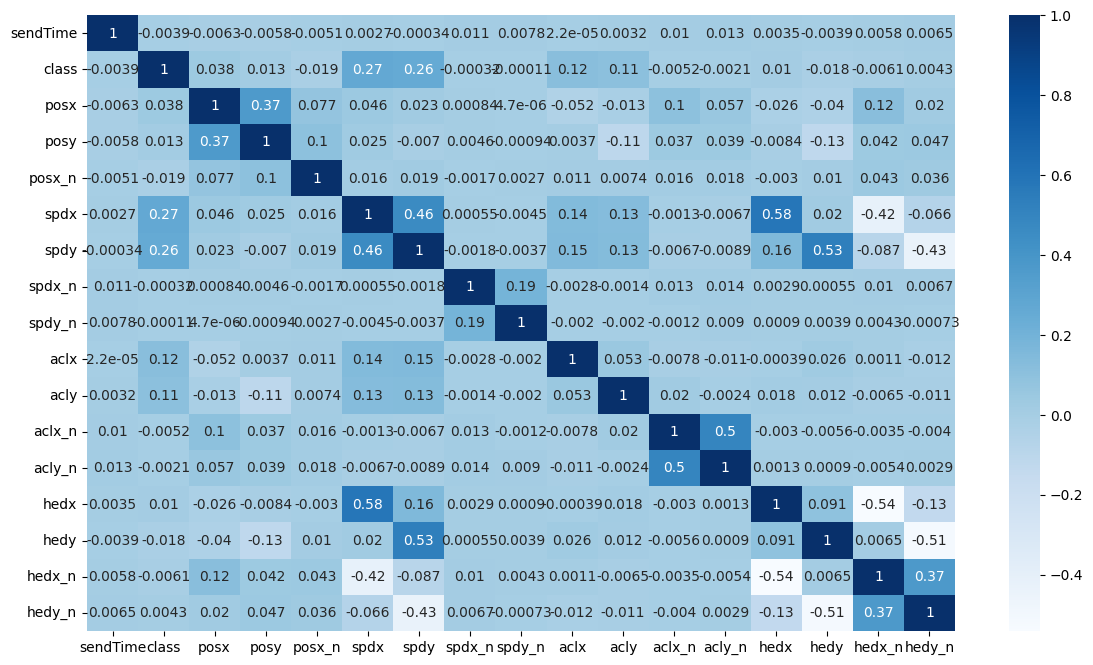

In [19]:
plt.figure(figsize=(14,8))
sns.heatmap(df_dataset.corr(), annot=True, cmap='Blues')

### 3 - Feature Normalization

In [21]:
X = df_dataset.drop(columns=['class'])

In [24]:
columns_names = X.columns
scaler = MinMaxScaler()
scaler = scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = columns_names
X

,sendTime,posx,posy,posx_n,spdx,spdy,spdx_n,spdy_n,aclx,acly,aclx_n,acly_n,hedx,hedy,hedx_n,hedy_n
0,0.832895,0.186486,0.035478,0.422140,0.401066,0.428433,0.549152,0.501666,0.589292,0.735230,0.005886,0.006455,0.448605,0.997352,0.165187,0.154279
1,0.832906,0.186385,0.036958,0.430069,0.398094,0.456817,0.549697,0.496845,0.589477,0.732937,0.000734,0.007787,0.450072,0.997501,0.168508,0.127245
2,0.832918,0.186120,0.039684,0.429800,0.395135,0.485086,0.550567,0.489147,0.592305,0.697983,0.001172,0.012436,0.450072,0.997501,0.171883,0.105030
3,0.832930,0.187739,0.043942,0.405064,0.391788,0.516723,0.551434,0.481480,0.592017,0.700927,0.001167,0.012385,0.449914,0.997485,0.175780,0.084734
4,0.832941,0.187304,0.049324,0.403705,0.388570,0.547374,0.552414,0.472899,0.585891,0.776429,0.001319,0.013861,0.451447,0.997637,0.179612,0.068820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194803,0.918486,0.933626,0.575476,0.481861,0.510245,0.416702,0.773943,0.518385,0.623796,0.506468,0.002684,0.085372,0.353377,0.540445,0.392858,0.116885
3194804,0.918491,0.624729,0.311073,0.438483,0.416916,0.415221,0.549152,0.501666,0.802514,0.581719,0.004263,0.004676,0.975014,0.656084,0.114531,0.130112
3194805,0.918497,0.684644,0.296833,0.491035,0.434399,0.410844,0.771950,0.465536,0.630209,0.582817,0.000045,0.000073,0.415166,0.232487,0.390781,0.116834
3194806,0.918503,0.139047,0.415732,0.452500,0.574688,0.326844,0.500268,0.812232,0.595859,0.610664,0.003873,0.000697,0.567558,0.004585,0.006958,0.031078


## Label Pre-Processing

### Generating Labels One-Hot Enconding

In [26]:
y = df_dataset['class']
y = pd.get_dummies(y,columns=['class'])

### Format Data

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.8,random_state=42)
x_train = np.resize(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test = np.resize(x_test,(x_test.shape[0],1,x_test.shape[1]))

## Model Implementation

In [30]:
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='tanh',return_sequences=True,input_shape=(20,X.shape[1]))))
model.add(Dropout(0.2))
model.add(Dropout(0.2))
model.add(Dense(24,activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(20,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

2024-06-12 14:41:29.094028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 14:41:29.094240: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/lcastrod/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  s

## Model Training

In [34]:
model.fit(x_train,y_train,epochs=500,batch_size=64)

Epoch 1/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.5246 - loss: 0.2172
Epoch 2/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.6229 - loss: 0.1171
Epoch 3/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6296 - loss: 0.1125
Epoch 4/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6353 - loss: 0.1095
Epoch 5/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6431 - loss: 0.1078
Epoch 6/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6477 - loss: 0.1065
Epoch 7/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6493 - loss: 0.1059
Epoch 8/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6518 - loss: 0.1051
Epoch 9/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6536 - loss: 0.1046
Epoch 10/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6556 - loss: 0.1041
Epoch 11/500
9984/9984 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.6566 - loss: 0.1038
Epoch 12

## Model Evaluation

In [ ]:
model.evaluate(x_test,y_test)